In [3]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
%autoreload 2

In [5]:
import logging
from pathlib import Path
import textwrap
import copy
from PIL import Image, ImageDraw, ImageFont
from waveshare_epd import epd2in7b
from waveshare_epd import epd5in83

In [6]:
import constants


In [7]:
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)

In [71]:
class TextBlock:
    '''Class for creating a 1 bit image of word-wrapped text
    
    Args
    ----
        resolution (int, int): tuple of ints representing maximum resolution of image
        text (str): text to format into image
        font (str): path to ttf font
        size (int): size of font in points (pixles)
        max_lines (int): maximum number of wrapped rows of text; surplus is discarded
        maxchar (int): maximum number of characters per row
            this is automatically calculated if not specified based on font face, font size
            and letter frequency (see chardist below)
        chardist (dict): character frequency distribution for a particular language
            provided distributions in constants.py: 
            USA_CHARDIST+, FRA_CHARDIST, DEU_CHARDIST, PRT_CHARDIST, ITA_CHARDIST, TUR_CHARDIST,
            SWE_CHARDIST, NED_CHARDIST, DAN_CHARDIST
                + only USA english includes upper and lower case characters
        coordinates (int, int): location on screen image should be positioned (not used locally)
    
    Attributes
    ----------
        resolution (int, int): max resolution of image in px
        font (ImageFont.trueType): font and size to use
        maxchar (int): maximum number of characters per row
        max_lines (int): maximum number of wrapped rows of text; surplus is discarded
        coordinates (int, int): position of text in final image (not used in this class)
        size (int, int): size of text image in px
        text (str): raw text
        formatted (str): wrapped text
        textimage (ImageDraw.Draw): 1 bit image containing formatted text text


    '''
    def __init__(self, resolution=(600, 448), text=' ', font=constants.FONT, size=24, max_lines=3,
                 maxchar=None, center=False, coordinates=(0, 0), chardist=constants.USA_CHARDIST):
        self.resolution=resolution
        self.font = ImageFont.truetype(str(Path(font).absolute()), size)
        self._chardist = chardist
        self.maxchar = maxchar
        self.center = center
        self.dimensions = (0, 0)
        self.max_lines = max_lines
        self.coordinates = coordinates
        self.image = None
        self.text = text
    
        
    @property
    def resolution(self):
        '''maximum resolution in for image
        
        ::2-tuple of int'''
        return self._resolution
    
    @resolution.setter
    def resolution(self, resolution):
#         for r in resolution:
#             if not isinstance(r, int):
#                 raise TypeError(f'resolution must be type int: {r}')
#             if r < 0:
#                 raise ValueError(f'resolution must be positive: {r}')
        if self.coordcheck(resolution):
            self._resolution = resolution
        else:
            raise ValueError(f'bad resolution value: {resolution}')
    
    @property
    def coordinates(self):
        '''coordinates to place the formatted text within the final image (not used in this method)
        
        ::2 tuple of int'''
        return self._coordinates
    
    @coordinates.setter
    def coordinates(self, coordinates):
        if self.coordcheck(coordinates):
            self._coordinates = coordinates
        else:
            raise ValueError(f'bad coordinate values: {coordinates}')
    
    @property
    def maxchar(self):
        '''maximum number of characters per row
            if no value is set this is calculated based on font face, font size and letter frequency
            
        ::int'''
        return self._maxchar
    
    @maxchar.setter
    def maxchar(self, maxchar):
        if maxchar:
            self.__maxchar = maxchar
            return(maxchar)
        else:
            s = ''
            n = 1000 # sample string size for measuring
            # create a string of characters containing the letter distribution
            for char in self._chardist:
                s = s+(char*int(self._chardist[char]*n))
            sLenPX = self.font.getsize(s)[0] # string length in Pixles
            avgCharLen = sLenPX/len(s)
            maxchar = round(self.resolution[0]/avgCharLen)
            self._maxchar = maxchar
            logging.debug(f'maximum characters/line: {maxchar}')
    
    @property
    def text(self):
        '''raw text
        
        ::str'''
        return self._text
    
    @text.setter
    def text(self, text):
        if not text:
            self.text = None
        else:
            self._text = text
            self.formatted = self.formattext()
            self.image = self.textimage()
    
    @property
    def max_lines(self):
        '''maximum number of rows to use when wrapping text
        
        ::int'''
        return self._max_lines
    
    @max_lines.setter
    def max_lines(self, max_lines):
        if max_lines < 1:
            raise ValueError(f'max_lines must be greater than 0: {max_lines}')
        if not isinstance(max_lines, int):
            raise ValueError(f'max_lines must be type integer: {max_lines}')
        self._max_lines = max_lines
    
    def formattext(self, text=None, maxchar=None, max_lines=None):
        '''format text using word-wrap strategies
        
        Args
        ----
            text (str): raw text
            maxchar (int): maximum number of characters in each row
            max_lines (int): maximum number of rows
            justify (str): 'l'-left (default), 'c'-center
            
        Returns
        -------
            ::list of ::str'''
        
        if not maxchar:
            maxchar = self.maxchar
        if not max_lines:
            max_lines = self.max_lines
        if not text:
            text = self.text

        wrapper = textwrap.TextWrapper(width=maxchar, max_lines=max_lines)
        myText = wrapper.wrap(text)
        
        # pad out unused lines in max_lines
        if len(myText) < max_lines:
            for i in range(len(myText), max_lines):
                myText.append(" ")
        
        logging.debug(f'total lines: {len(myText)}')
        
        logging.debug(myText)
    
        
        return(myText)
    
    def textimage(self, text=None, coordinates=None, center=None):
        '''produces 1 bit image of containing wrapped text
        
        Args
        ----
            text (str): raw text to use; if none is provided use self.formatted
            coordinates (int): coordinates of text in final image (not used in this class)
            
        Returns
        -------
            ::Image.new()'''
        if text:
            text = self.formattext(text)
        else:
            text = self.formatted
        
        if not center:
            center = self.center
        
        if not coordinates:
            coordinates = self.coordinates
        
        tallest = self.font.getsize('Q')[1]
        current_h = 0
        pad = round(tallest*.1)
        current_w = 0
        # determine the dimensions of each line of text and total dimensions
        for line in self.formatted:
            w, h = self.font.getsize(line)
            current_h += h + pad # accumulate the total height
            if w > current_w: # find the longest line
                current_w = w 
        dimensions = (current_w, current_h)
        logging.debug(f'text dimension: {dimensions}')
        self.dimensions = dimensions
        image = Image.new('1', dimensions, 255)
        draw = ImageDraw.Draw(image)
        current_h = 0
        y_pos = 0
        # loop through the lines again to build the image
        for line in self.formatted:
            w, h = self.font.getsize(line)
            if center:
                y_pos = (dimensions[0]-w)/2
            draw.text((y_pos, current_h), line, font=self.font)
            current_h += h + pad
        
        if center:
            new_coordinates = (round(self.resolution[0]/2-self.dimensions[0]/2)+self.coordinates[0], 
                               self.coordinates[1])
            self.coordinates = new_coordinates
        
        return image

    def coordcheck(self, coordinates):
        for c in coordinates:
            if not isinstance(c, int):
                raise TypeError(f'coordinate must be type int: {c}')
                return False # redundant
            if c < 0:
                raise ValueError(f'coordinate must be positive: {c}')
                return False # redundant
        return True

In [93]:
t = TextBlock(text="Bach: Cello Suite #2 In D Minor, BWV 1008 - 1. Prelude", size=60, coordinates=(0, 0), center=True)

DEBUG:root:maximum characters/line: 18
DEBUG:root:total lines: 3
DEBUG:root:['Bach: Cello Suite', '#2 In D Minor, BWV', '1008 - 1. Prelude']
DEBUG:root:text dimension: (548, 229)


In [94]:
t.coordinates


(26, 0)

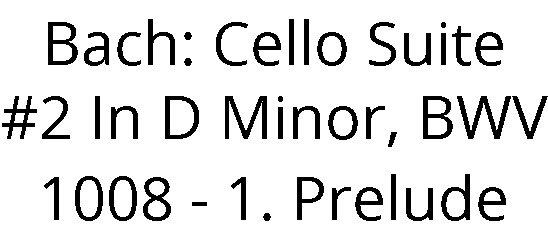

In [95]:
t.image

In [96]:
a = TextBlock(text="Edgar Meyer", size=36, coordinates=(5, t.dimensions[1]), max_lines=2)

DEBUG:root:maximum characters/line: 29
DEBUG:root:total lines: 2
DEBUG:root:['Edgar Meyer', ' ']
DEBUG:root:text dimension: (212, 95)


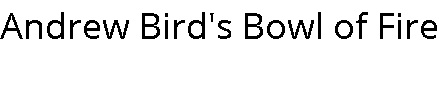

In [77]:
a.image

In [89]:
class Screen:
    def __init__(self, resolution=(600, 448), elements=[], epd=None):
        self.resolution = resolution
        self.elements = elements
        self.image = self.clearScreen()
        self.epd = epd
        
    @property
    def resolution(self):
        return self._resolution
    
    @resolution.setter
    def resolution(self, resolution):
        if self.coordcheck(resolution):
            self._resolution = resolution
    
    def clearScreen(self):
        '''sets base image for building screen to an empty background'''
        self.image = Image.new('1', self.resolution, 255)
        return self.image

    def concat(self, elements=None):
        if elements:
            elements = elements
        else:
            elements = self.elements
    
        for e in self.elements:
            self.image.paste(e.image, (e.coordinates))
        return(self.image)
        
    def coordcheck(self, coordinates):
        for c in coordinates:
            if not isinstance(c, int):
                raise TypeError(f'coordinate must be type int: {c}')
                return False # redundant
            if c < 0:
                raise ValueError(f'coordinate must be positive: {c}')
                return False # redundant
        return True        
    
    def initEPD(self):
        if not self.epd:
            raise UnboundLocalError('no epd object has been assigned')
        try:
            self.epd.init()
        except Exception as e:
            logging.error(f'failed to init epd: {e}')
    
    def clearEPD(self):
        if not self.epd:
            raise UnboundLocalError('no epd object has been assigned')
        try:
            self.epd.Clear();
        except Exception as e:
            logging.error(f'failed to clear epd: {e}')
    
    def writeEPD(self, image=None, sleep=True):
        epd = self.epd
        if not self.epd:
            raise UnboundLocalError('no epd object has been assigned')
        try:
#             epd.display(epd.getbuffer(self.image), epd.getbuffer(Image.new('1', (epd.height, epd.width), 255)))
            epd.display(epd.getbuffer(self.image))
            if sleep:
                epd.sleep()
        except Exception as e:
            logging.error(f'failed to write to epd: {e}')
        
        

In [ ]:
e = epd5in83.EPD()

In [ ]:
e.height, e.width

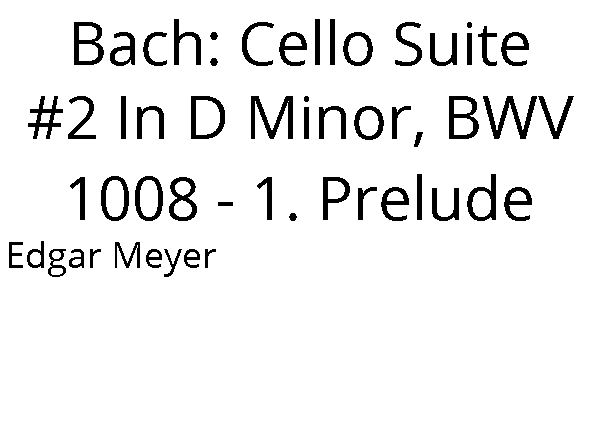

In [97]:
s = Screen(elements=[a, t])
s.concat()

In [98]:
s.epd = epd5in83.EPD()
s.initEPD()
# s.clearEPD()
s.writeEPD()

DEBUG:root:e-Paper busy
DEBUG:root:e-Paper busy release
DEBUG:root:imwidth = 600  imheight =  448 
DEBUG:root:e-Paper busy
DEBUG:root:e-Paper busy release
DEBUG:root:e-Paper busy
DEBUG:root:e-Paper busy release
DEBUG:root:spi end
DEBUG:root:close 5V, Module enters 0 power consumption ...
